# Vanilla sparse coding tutorial notebook
This is an introduction to sparse coding implemented using Euler's method to compute coefficients $a_i$ (see below for definitions). It is a simplified, standalone tutorial and **does not** utilize the sparse coding library structure in `rctn/sparsecoding/`. Here we use static images, but sparse coding can be applied to many other domains.

For technical details, see [1][Olshausen & Field 1996](http://redwood.psych.cornell.edu/papers/olshausen_field_nature_1996.pdf) and [2][Olshausen & Field 1997](http://redwood.psych.cornell.edu/papers/olshausen_field_1997.pdf).

>🚨 Before starting:
>* Make sure you've installed everything in `requirements.txt`.
>* Download whitened natural images `IMAGES.mat` (20MB) from http://www.rctn.org/bruno/sparsenet/.

If you run into any issues, please [file a bug](https://github.com/rctn/sparsecoding/issues).

In [2]:
# This extension allows us to sync changes from utils without restarting kernel.
%reload_ext autoreload
%autoreload 1
%aimport src.utils

import torch
import torch.nn.functional as F
from src import utils
from tqdm import tqdm

🚨 Insert your image path below.

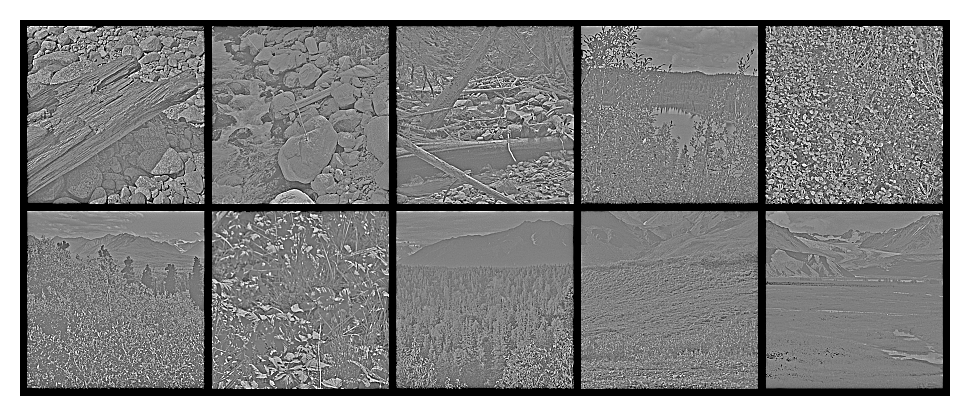

In [3]:
img_path = "path/to/IMAGES.mat"
imgs = utils.load_data(img_path)
utils.show_imgs(imgs)

## Problem definition
The sparse coding model is of the form 
$$ \tag{1} I(x,y) = \sum_i a_i \phi_i (x,y) + \epsilon(x,y)$$
* $I(x,y)$ denotes the pixel intensities within an image patch ($x$ and $y$ are spatial coordinates)
* The $\phi_i(x, y)$ are a set of basis functions, also referred to as a "dictionary" of features for describing the image
* $a_i$ correspond to the neural activity ($i$ denotes the index of the neuron)
* $\epsilon(x,y)$ is an additive noise term, assumed to be Gaussian

We wish to find a dictionary of features that allow images to be described using as few non-zero $a_i$ as possible. For example, given an image patch 

![patch](demo_imgs/patch_example.png)

one sparse reconstruction might be a combination of the following weighted features

![components](demo_imgs/components_example.png)

In other words, there are two goals:
1. Given a batch of images and a dictionary, infer sparse coefficients
2. Learn dictionary

## Energy function
To compute $a_i$ for a given image $I(x,y)$ while learning dictionary $\phi$, we minimize the energy function governing the system:
$$ \tag{2} E=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i \phi_i(x,y)\bigg]^2 + \lambda\sum_i C(a_i)$$
* The first term measures how well information is preserved, or how well the code describes the image, defined using mean squared error between the original image patch and the reconstruction.
* The second term assesses the sparseness of the code for a given image by assigning a cost defined by $C(a_i)$ depending on how activity is distributed among the coefficients. Representations where activity is spread over many coefficients should incur a higher cost than those where only few coefficients carry the load. Below we use $C(x) = |x|$, thus $C'(x) = \text{sign}(x)$.
* $\lambda$ is a positive constant that determines the importance of the second term relative to the first.
* In the code below, we refer to the reconstruction $\sum_i a_i \phi_i(x,y)$ as $\hat{I}$ (`Ihat`).



In [4]:
# Sparse nonlinearity for the sparsity penalty; we use |x|, but there are other possibilities.
def C(x): return torch.abs(x)
def C_prime(x): return torch.sign(x)

# Calculate two terms of energy function according to equation 2.
def E_terms(I, Ihat, a, lambd):
    mse = F.mse_loss(Ihat, I).data
    sparseness = lambd * torch.sum(C(a))
    return mse, sparseness 

## Inference of sparse codes
Given a dictionary, how do we infer sparse coefficients $a_i$? The most straightforward method is to explicitly minimize $E$ with respect to $a_i$. This is determined from the equilibrium solution to the differential equation
$$\tag{4} \dot{a_i} = \sum_{x,y}\phi_i(x,y)r(x,y)  - \lambda C'(a_i)$$

## Learning rule
How do we learn a dictionary $\phi$ that best accounts for the images? The most direct way is simple gradient descent on $E$ with respect to $\phi$
$$\tag{3} \Delta \phi_i(x,y) = \eta \langle a_i r(x,y)\rangle$$
* $r(x,y)$ = $I(x,y) - \sum_i a_i \phi_i(x,y)$ is the "residual image"
* $\langle \rangle$ indicates inner product
* $\eta$ is the learning rate

There are many learning and inference methods, some of which can be found in this repository.

## Defining parameters
For your first time running this notebook, we suggest using the preset parameters to make sure everything is working. After that, we recommend playing with the parameters to see how the outputs change.

In [5]:
# Tunable parameters.
epochs = 3000
num_infer_iters = 300
batch_size = 100
lambd = 0.8
phi_lr = 1e-3
eta = 1e-3

# Init image variables.
num_bases = 64  # Size of feature dictionary.
patch_size = 8  # Each image is 8x8 pixels.
N = patch_size**2  # Number of pixels per image.

# Setting seed may be helpful for debugging and reproducibility.
seed = 0
rng = torch.Generator()
torch.manual_seed(seed)

# Initialize dictionary.
phi = torch.randn(N, num_bases)
phi = F.normalize(phi, dim=0)

Next, create a batch of image patches, which are cropped from the larger images. For each `epoch`, we collect a random subset of image patches from the set of all possible crops.

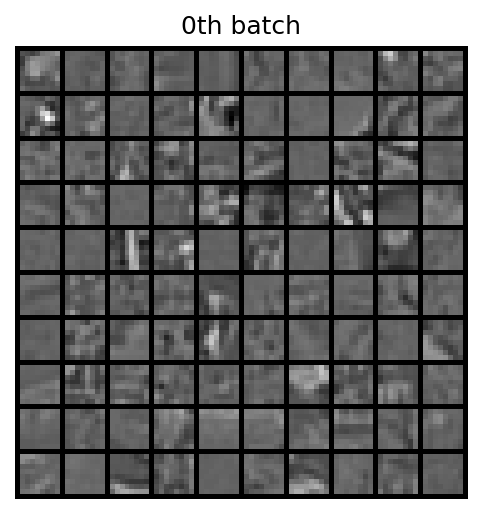

In [6]:
patches = utils.create_patches(imgs, epochs, batch_size, N, rng)
utils.show_patches(patches[0,:, :], title="0th batch")

## Let's run some code!
The main sparse coding algorithm consists of an outer loop that learns the dictionary features and an inner loop that infers coefficients based on the current dictionary.

In [7]:
# Store losses and phi snapshot for plotting later.
phi_snapshot_steps = 500
mses = []
sparse_costs = []

for i in tqdm(range(epochs)):
    I = patches[i, :, :]
    a = torch.zeros(batch_size, num_bases)
    Ihat = torch.mm(phi, a.T).T
    r = I - Ihat

    # This inner for loop uses Euler's method to infer coefficients a.
    for _ in range(num_infer_iters):
        da = eta * (torch.mm(r, phi) - (lambd * C_prime(a)))  # Equation 4.
        a += da

    # Update dictionary based on gradient with respect to phi.
    Ihat = torch.mm(phi, a.T).T 
    dphi = phi_lr * (torch.mm((I - Ihat).T, a))  # Equation 3.
    phi += dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)
    # Get phi snapshot to show later.
    if i == phi_snapshot_steps:  
        phi_snapshot = phi

    # Calculate energy for plotting purposes.
    mse, sparse_cost = E_terms(I, Ihat, a, lambd)
    mses.append(mse)
    sparse_costs.append(sparse_cost)


100%|██████████| 3000/3000 [00:55<00:00, 53.82it/s]


Let's look at our learned dictionary. When trained on natural images, they are localized, oriented, and bandpass as described in [1].


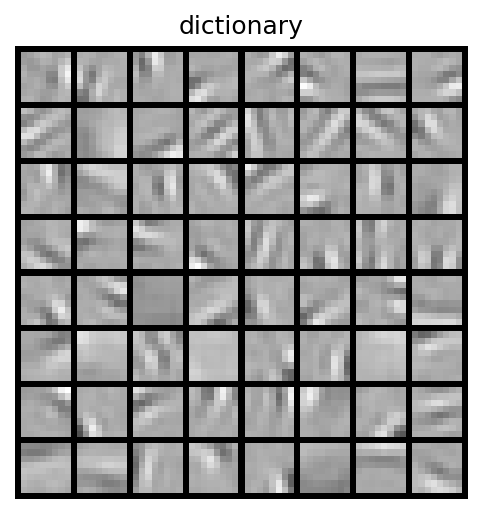

In [8]:
utils.show_dict(phi, "dictionary")

And here's how our reconstructions compare to the original patches, for one batch.

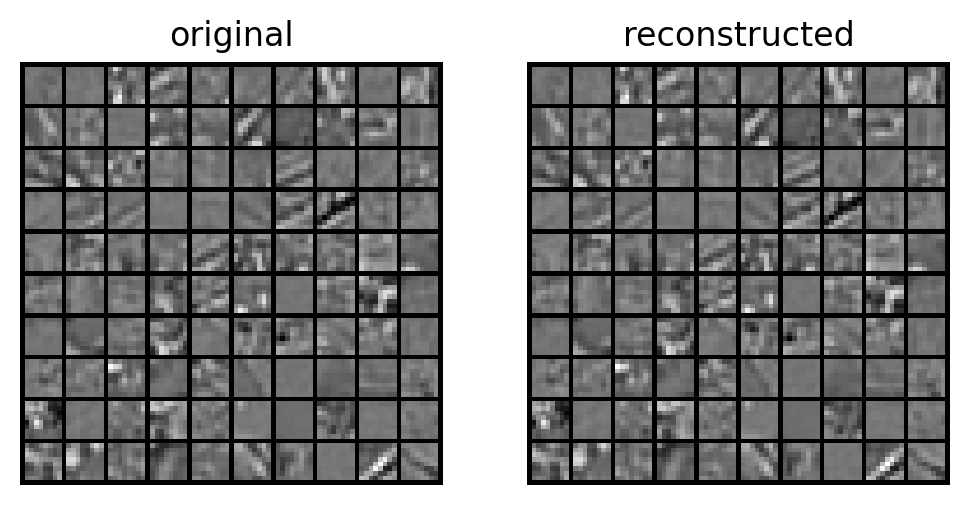

In [9]:
utils.show_patches_sbs(I, Ihat)

We can see how the MSE and sparsity cost change over time. The cost function jumps the most in the first few hundred steps, but the dictionary hasn't been fully learned yet:

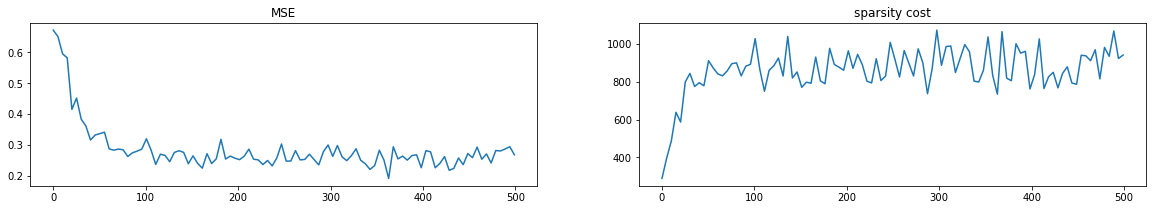

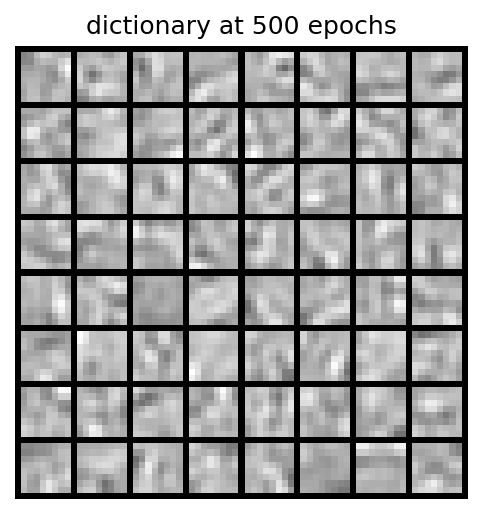

In [10]:
utils.plot_loss_sbs(mses[:phi_snapshot_steps], sparse_costs[:phi_snapshot_steps])
utils.show_dict(phi_snapshot, "dictionary at {} epochs".format(phi_snapshot_steps))

Although the remaining epochs don't exhibit a large change in the cost function, they are still necessary to get to a good solution:

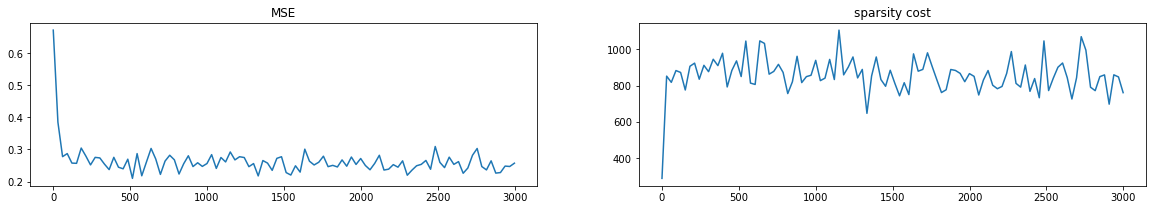

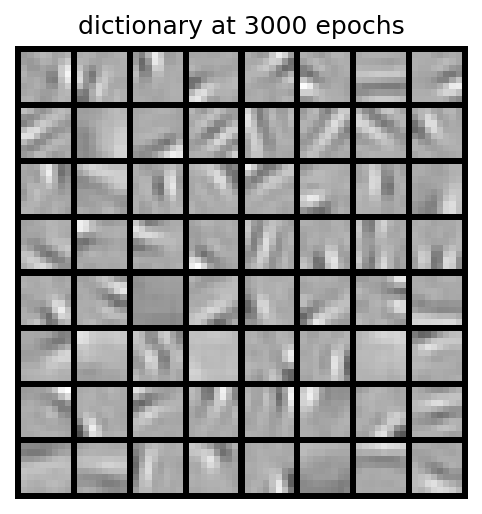

In [11]:
# Plot losses.
utils.plot_loss_sbs(mses, sparse_costs)
utils.show_dict(phi, "dictionary at {} epochs".format(epochs))

Let's focus on one patch. We can look at the stem plot of the coefficients and what bases are used to reconstruct the image. Each stem represents the value of one coefficient. The grid in the next cell shows each $\phi_i$ weighted by $a_i$, sorted by intensity.

![original](demo_imgs/original.png)
![coefficients](demo_imgs/coefficients.png)
![reconstruction](demo_imgs/reconstruction.png)

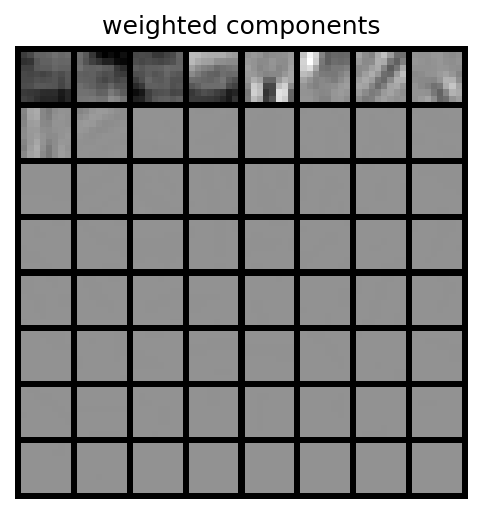

In [15]:
img_id = 0
coeff = a[img_id]
utils.show_components(phi, coeff, dpi=150)

Some codes are sparser than others. Let's take a look at the coefficients inferred for the first half of this batch. 

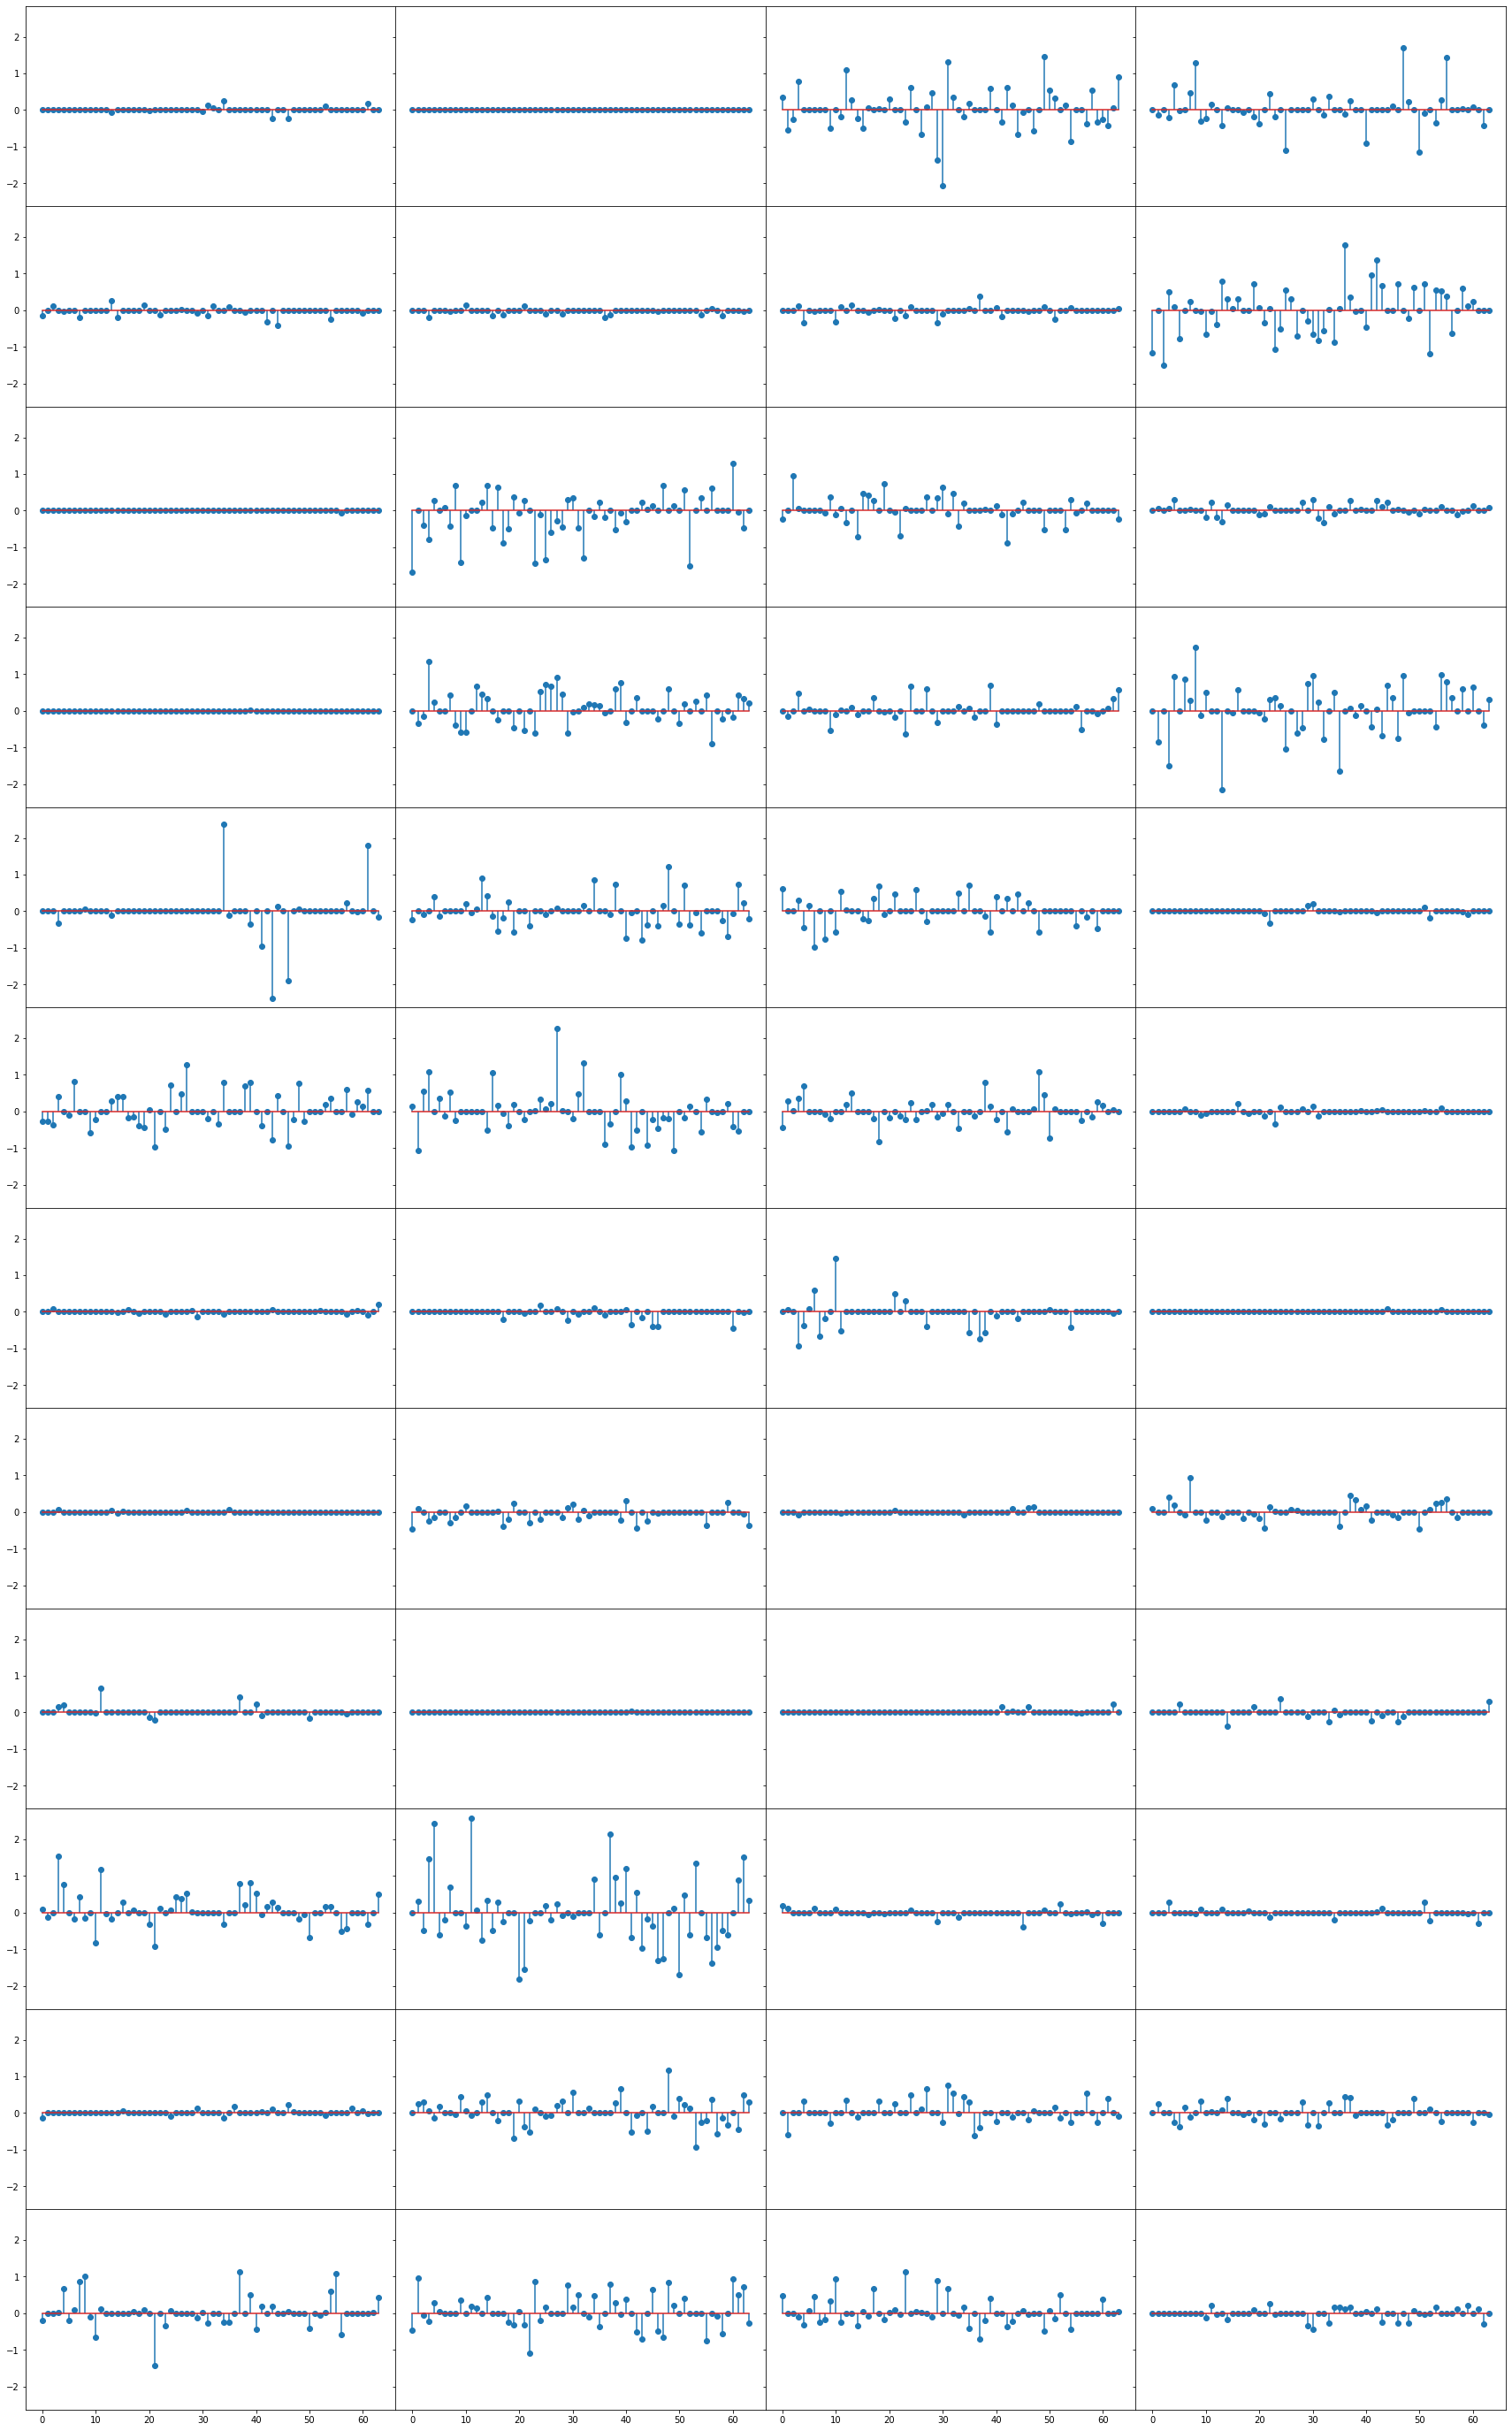

In [13]:
utils.coeff_grid(a)

This concludes the sparse coding tutorial. We encourage you to play with the parameters and see how they affect the results. 

The example here is only the tip of the iceberg. There are many varieties of sparse coding procedures for inference and learning. This repository is intended to provide these tools for researchers. Contributions are always welcome!